In [44]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data Import

In [45]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2021-01-02 17:30:01--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.172.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.172.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416277 (407K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>] 406.52K  1.19MB/s    in 0.3s    

2021-01-02 17:30:02 (1.19 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [416277/416277]



In [46]:
df = pd.read_csv('./datasets/time_series_covid19_confirmed_global.csv')

## Exploratory Data Analysis

In [47]:
# Let’s start by getting rid of the first four columns:
df = df.iloc[:, 4:]

# Let’s check for missing values:
df.isnull().sum().sum()

0

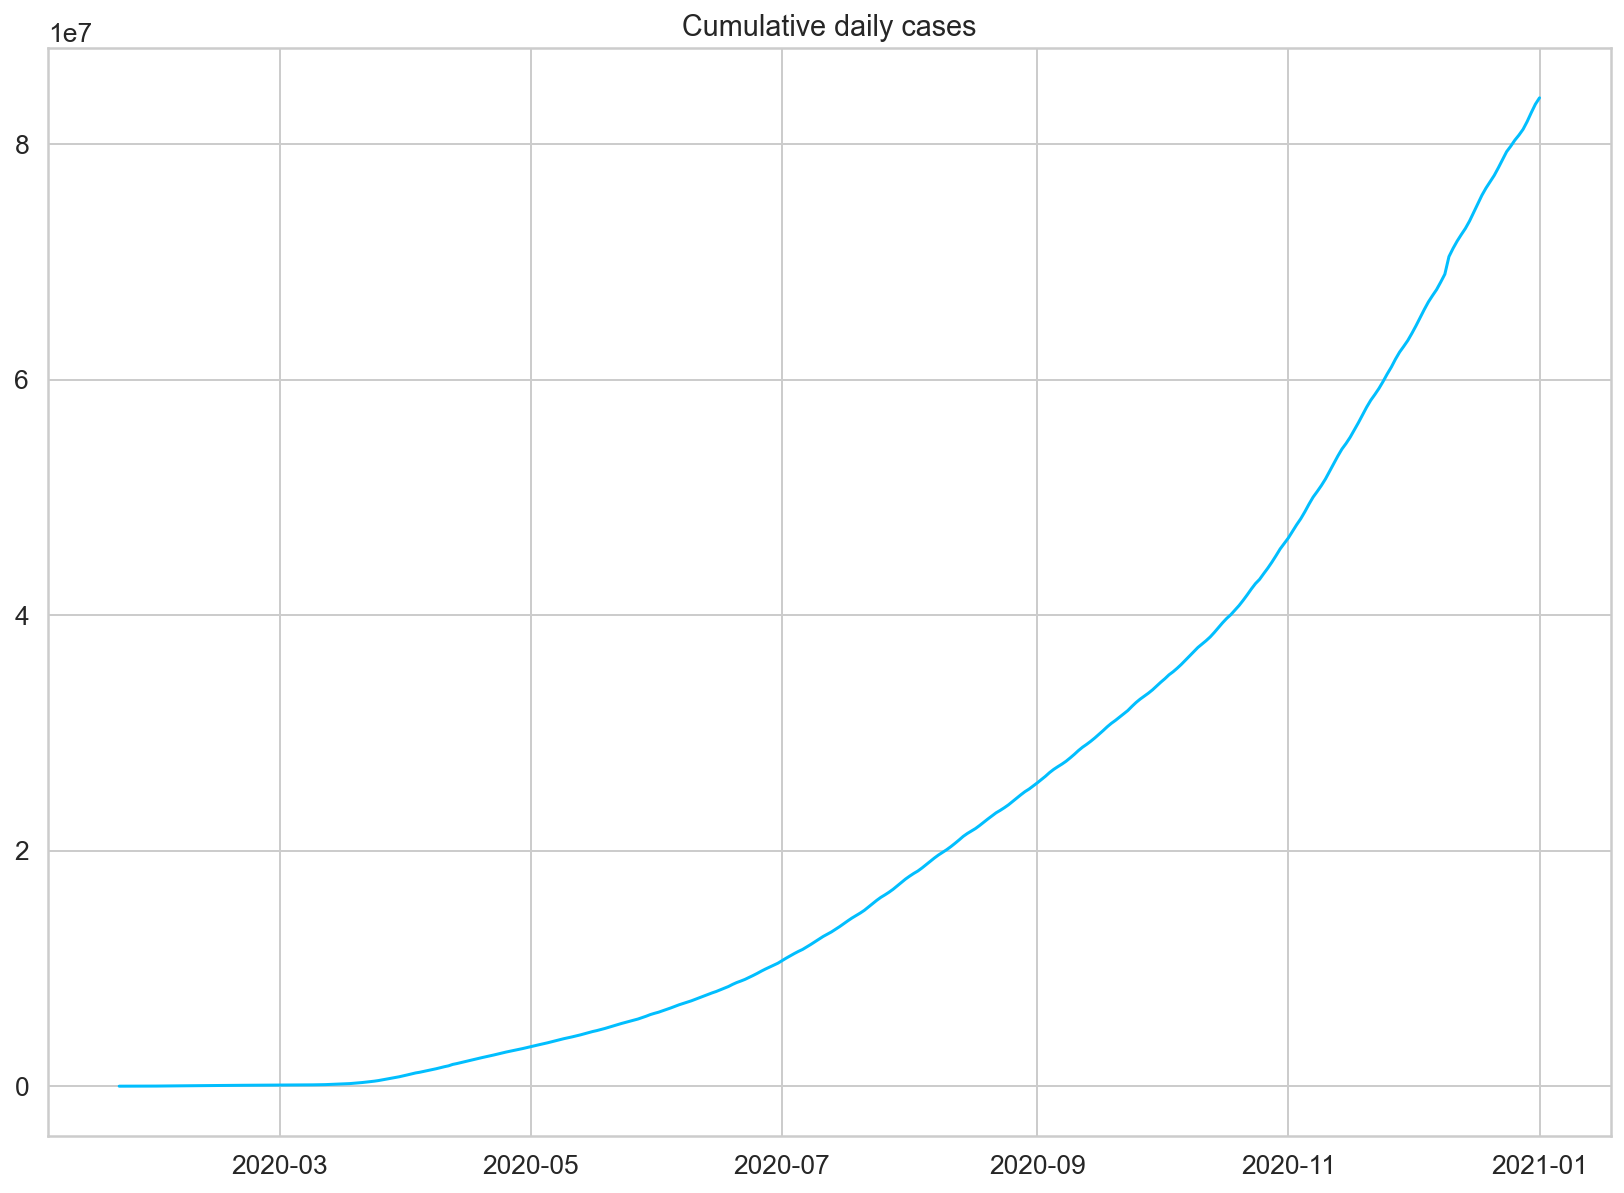

In [48]:
# Let’s sum all rows, so we get the cumulative daily cases:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

plt.plot(daily_cases)
plt.title("Cumulative daily cases");

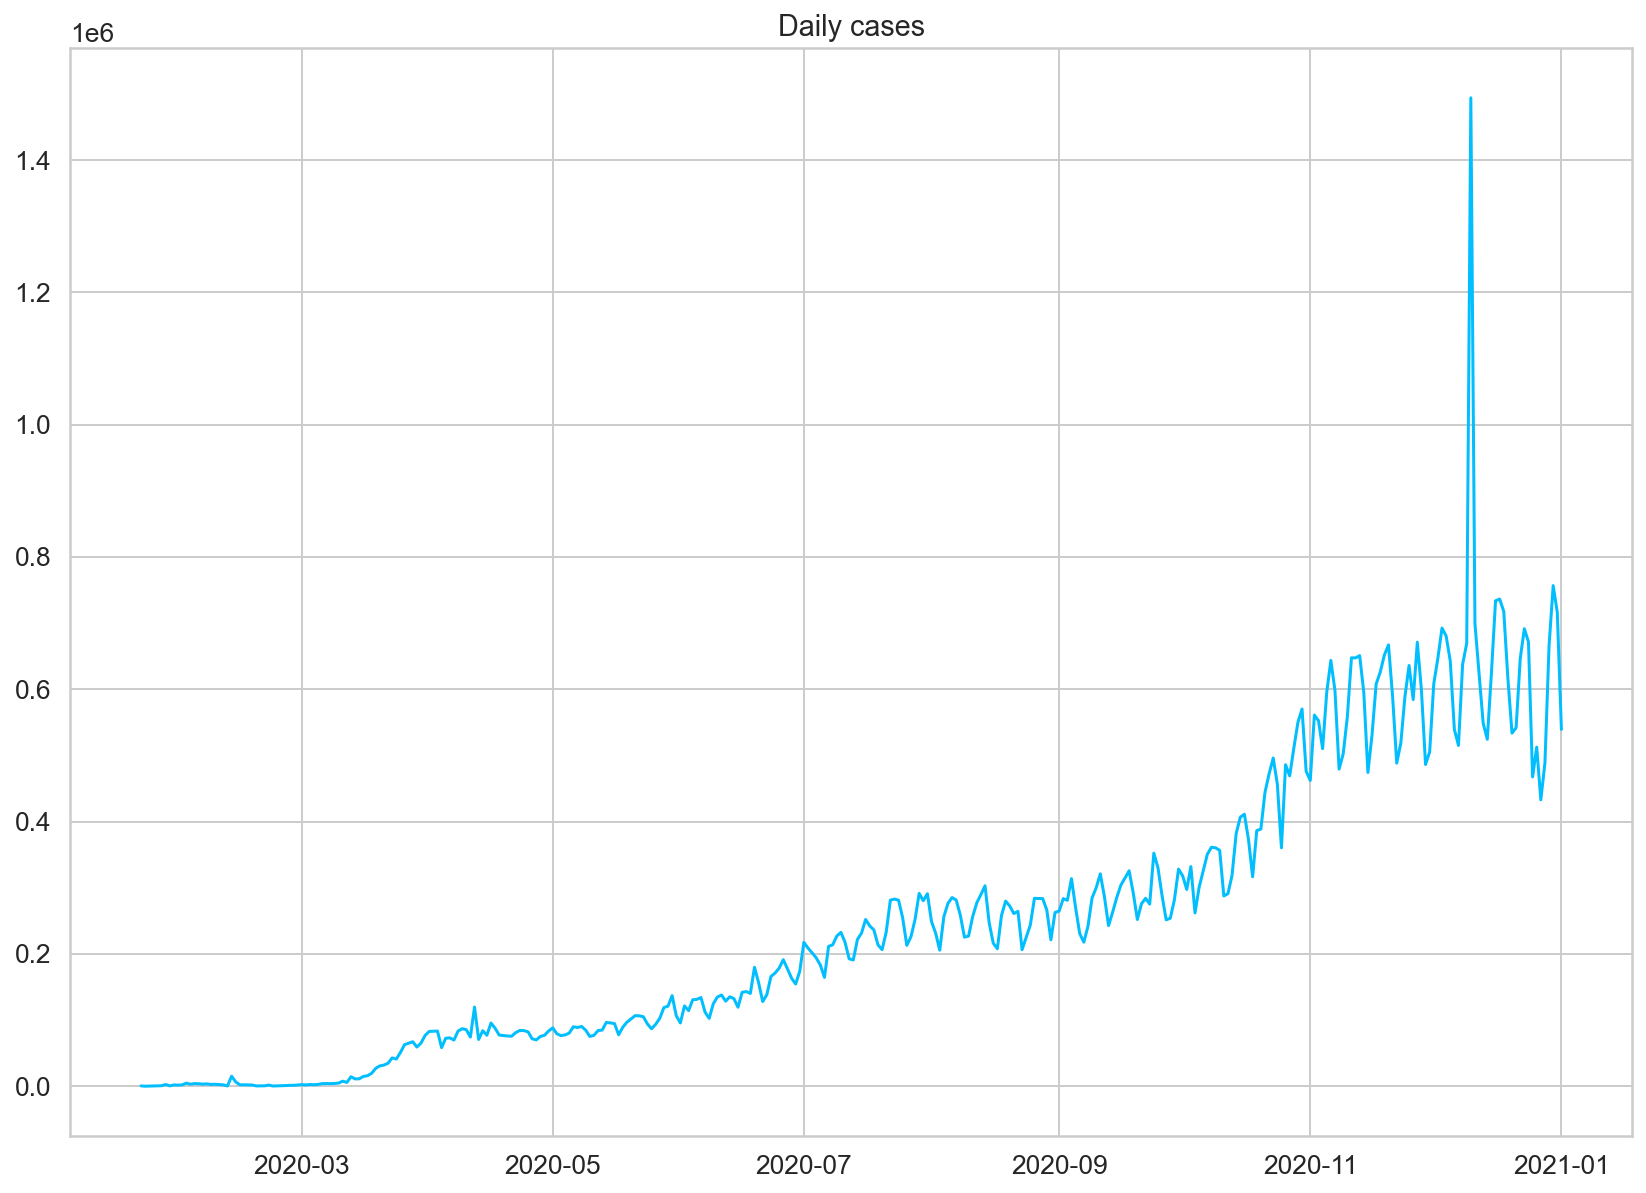

In [49]:
# We’ll undo the accumulation by subtracting the current value from the previous. We’ll preserve the first value of the sequence:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

plt.plot(daily_cases)
plt.title("Daily cases");

The huge spike (at the end) is mostly due to the december holiday period and the increased level of family gatherings - well, that's my assumption. This will certainly be a challenge for our model.

In [50]:
# Let's consider how many days of data we have to work with:
daily_cases.shape

(346,)

## Preprocessing

In [51]:
# We’ll reserve the first 300 days for training and use the rest for testing:
test_data_size = 300
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

In [52]:
# We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model.
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [53]:
# Currently, we have a big sequence of daily cases. We’ll convert it into smaller ones:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [54]:
seq_length = 5

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [55]:
# Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let’s dive in:
X_train.shape

torch.Size([40, 5, 1])

In [56]:
X_train[:2]

tensor([[[0.0303],
         [0.0000],
         [0.0125],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0125],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [57]:
y_train.shape

torch.Size([40, 1])

In [58]:
y_train[:2]

tensor([[0.0472],
        [0.1695]])

In [59]:
train_data[:10]

array([[0.03029095],
       [0.        ],
       [0.01248838],
       [0.02617245],
       [0.0388601 ],
       [0.04716354],
       [0.16952305],
       [0.03254949],
       [0.1307958 ],
       [0.10581905]])

## Build Model

In [60]:
# We’ll encapsulate the complexity of our model into a class that extends from torch.nn.Module:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

## Training

In [61]:
# Let’s build a helper function for the training of our model (we’ll reuse it later):
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)

      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
  return model.eval(), train_hist, test_hist

In [62]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 1.8156325817108154 test loss: 160378.921875
Epoch 10 train loss: 1.0253721475601196 test loss: 158554.265625
Epoch 20 train loss: 1.0248141288757324 test loss: 158999.875
Epoch 30 train loss: 1.0133792161941528 test loss: 159939.203125
Epoch 40 train loss: 1.0285311937332153 test loss: 161415.15625
Epoch 50 train loss: 1.0129985809326172 test loss: 162536.5625


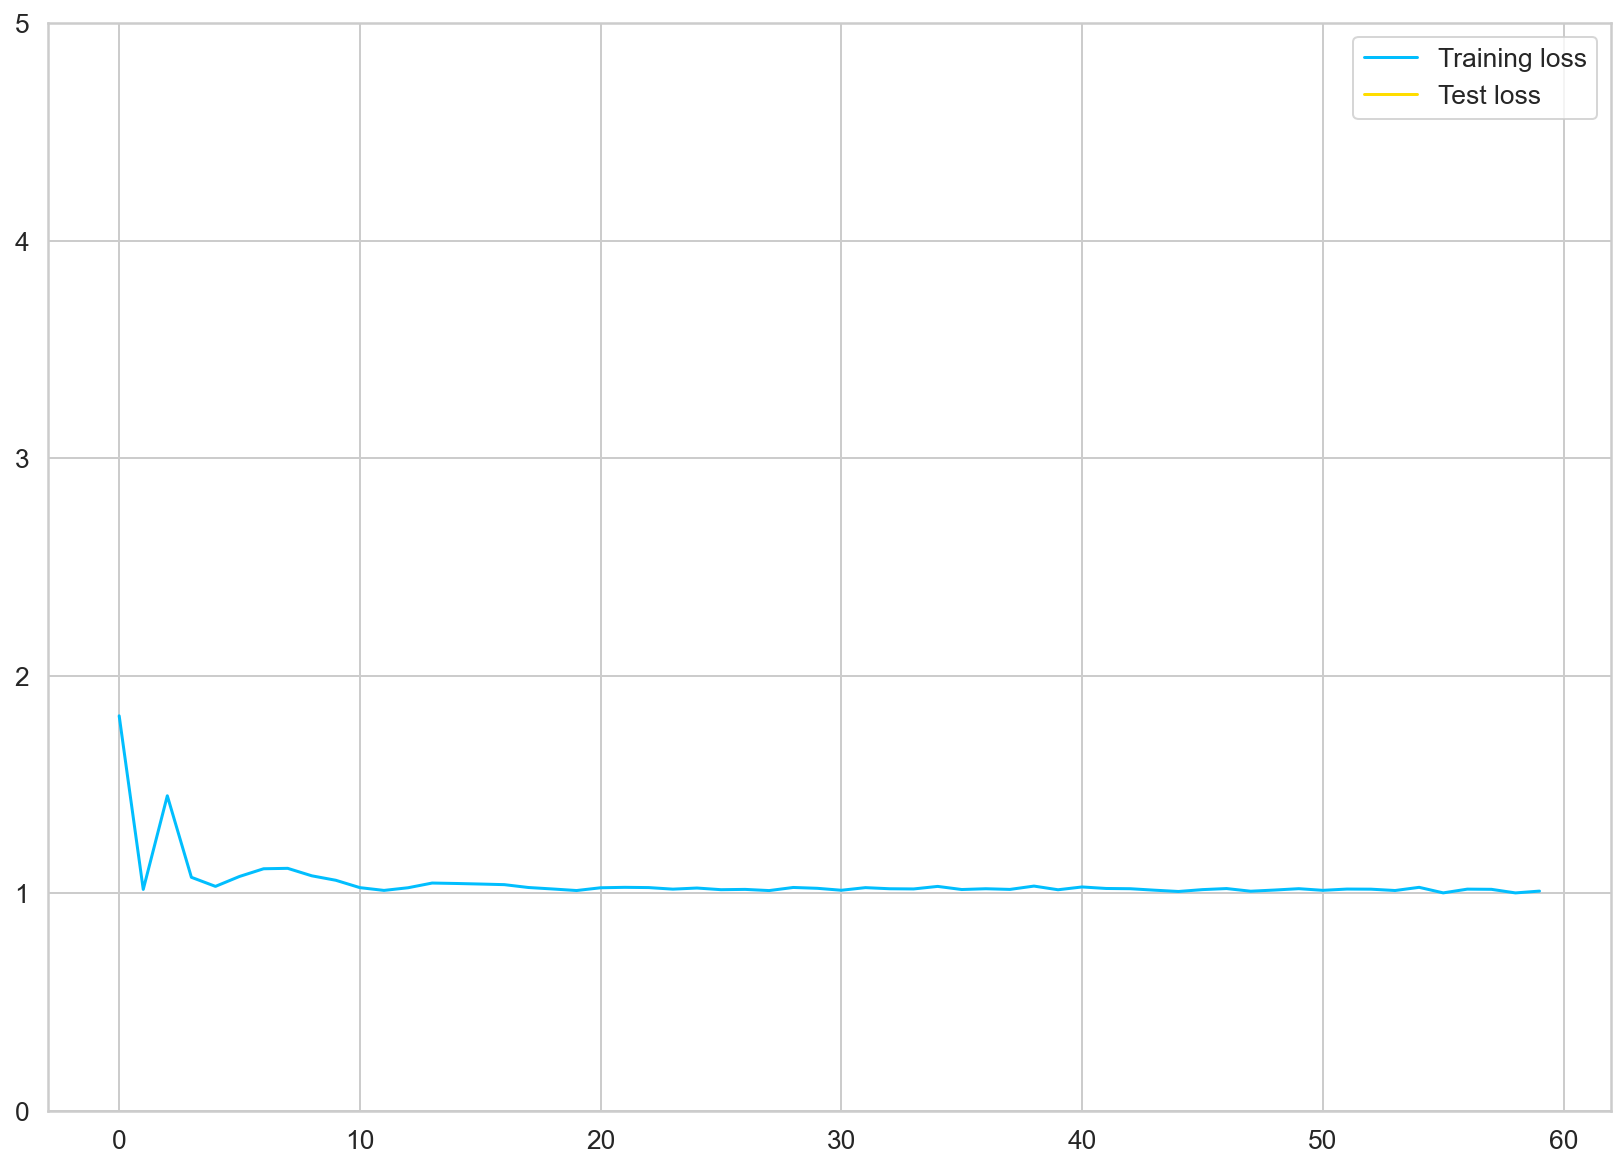

In [63]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

## Predicting Daily Cases

In [64]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [65]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

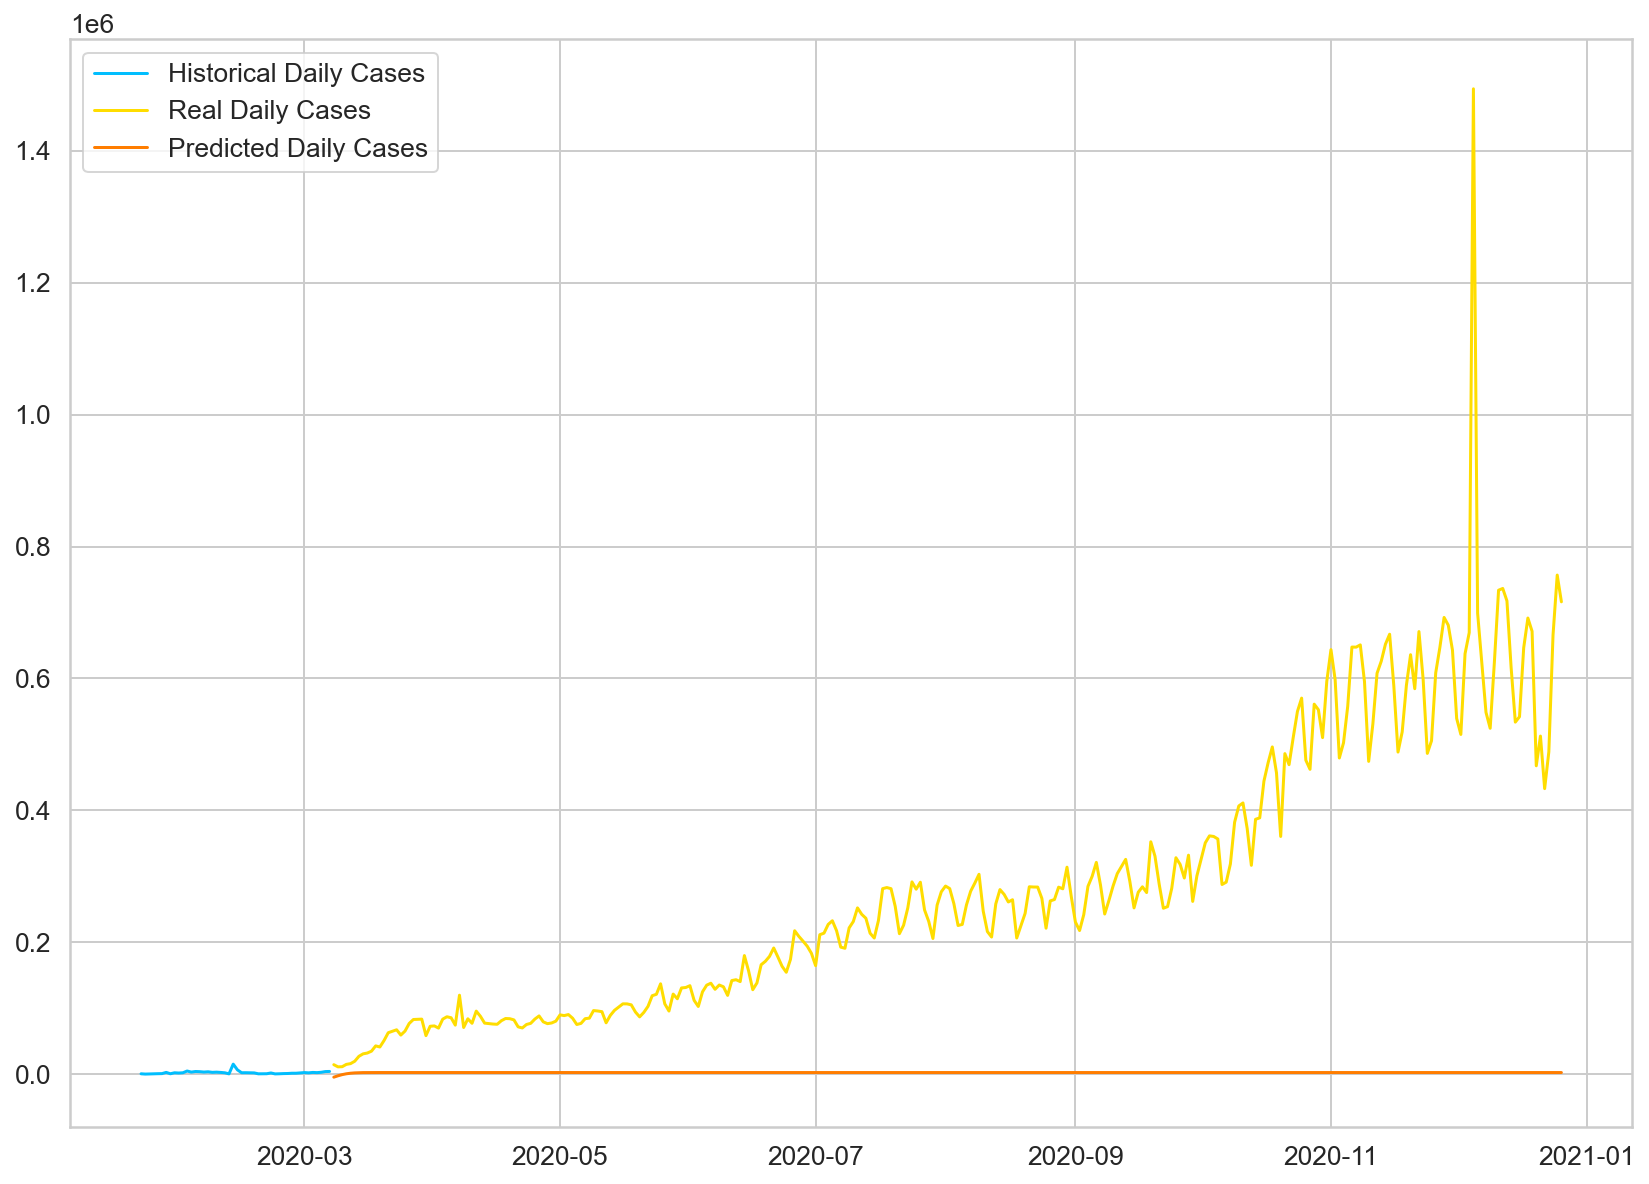

In [66]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend()

In [67]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(346, 1)

In [68]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 2.2693028450012207
Epoch 10 train loss: 1.0498045682907104
Epoch 20 train loss: 0.9999004602432251
Epoch 30 train loss: 1.029180645942688
Epoch 40 train loss: 1.0226845741271973
Epoch 50 train loss: 1.0264745950698853


In [69]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [70]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [71]:
daily_cases.index[-1]

Timestamp('2021-01-01 00:00:00')

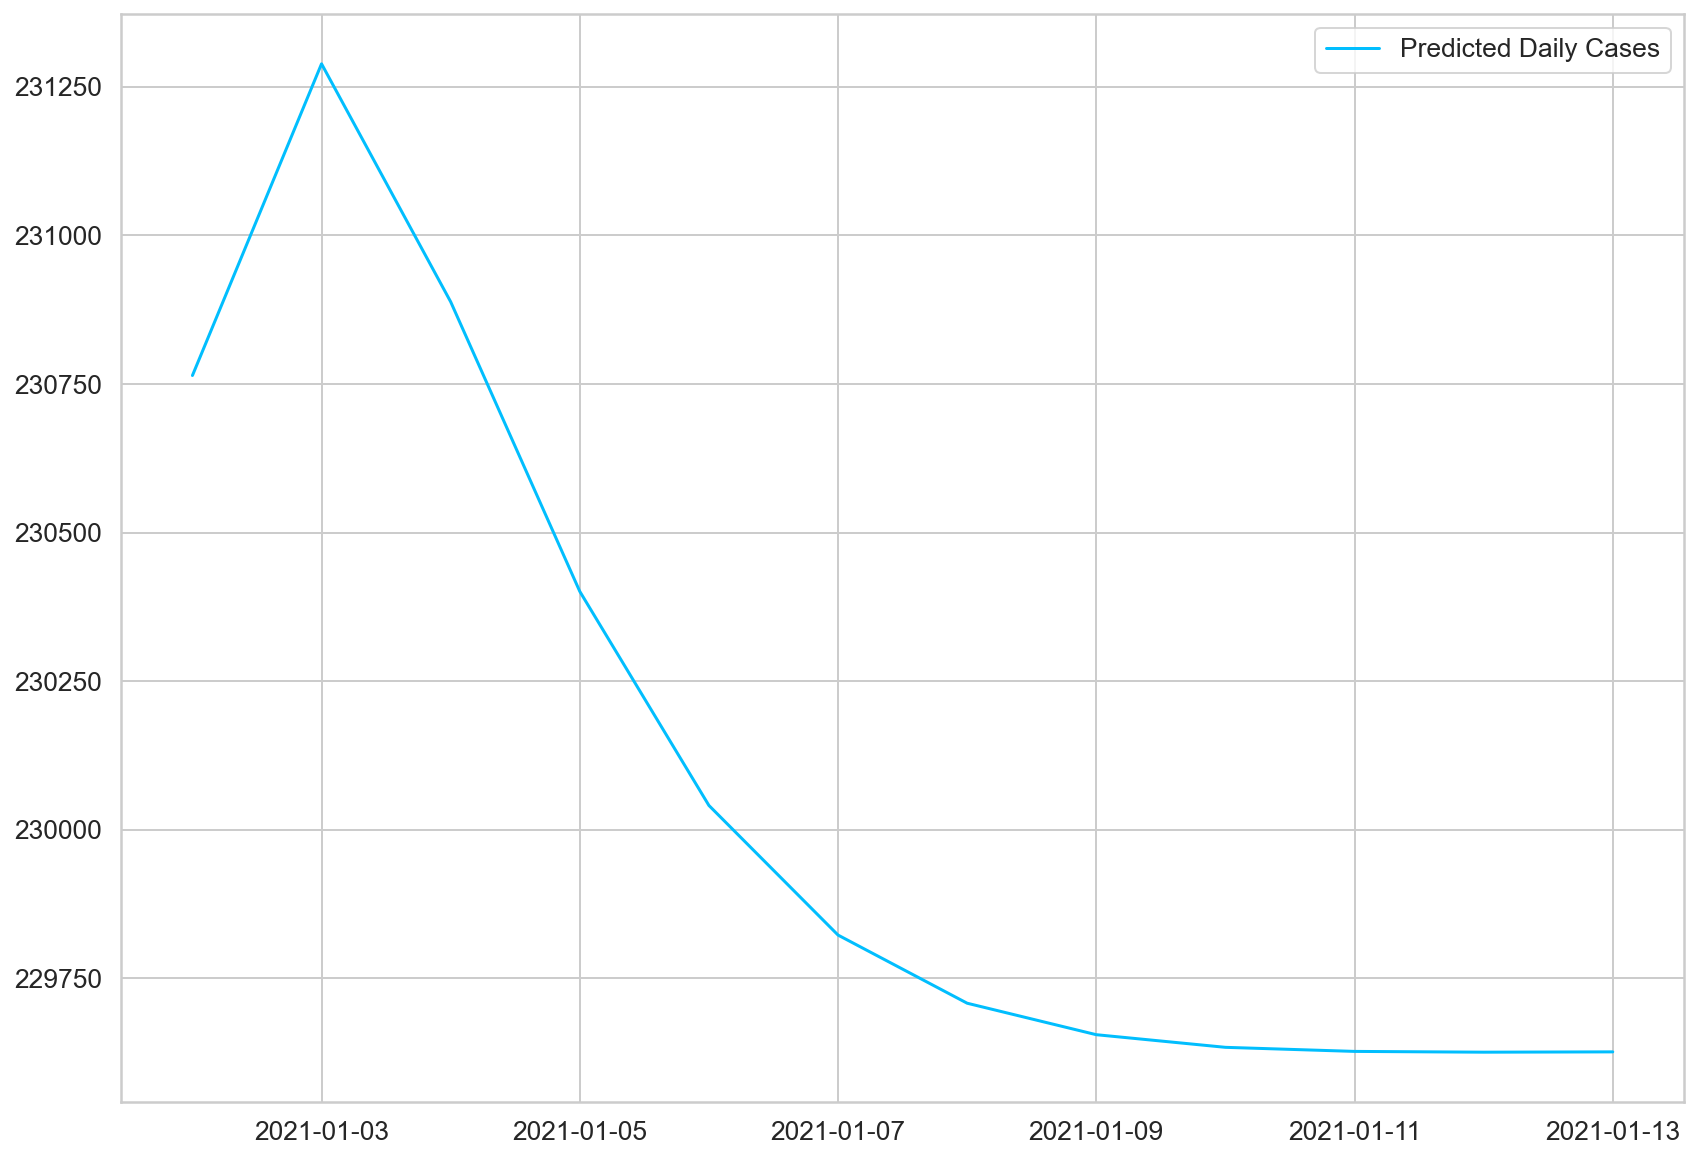

In [72]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

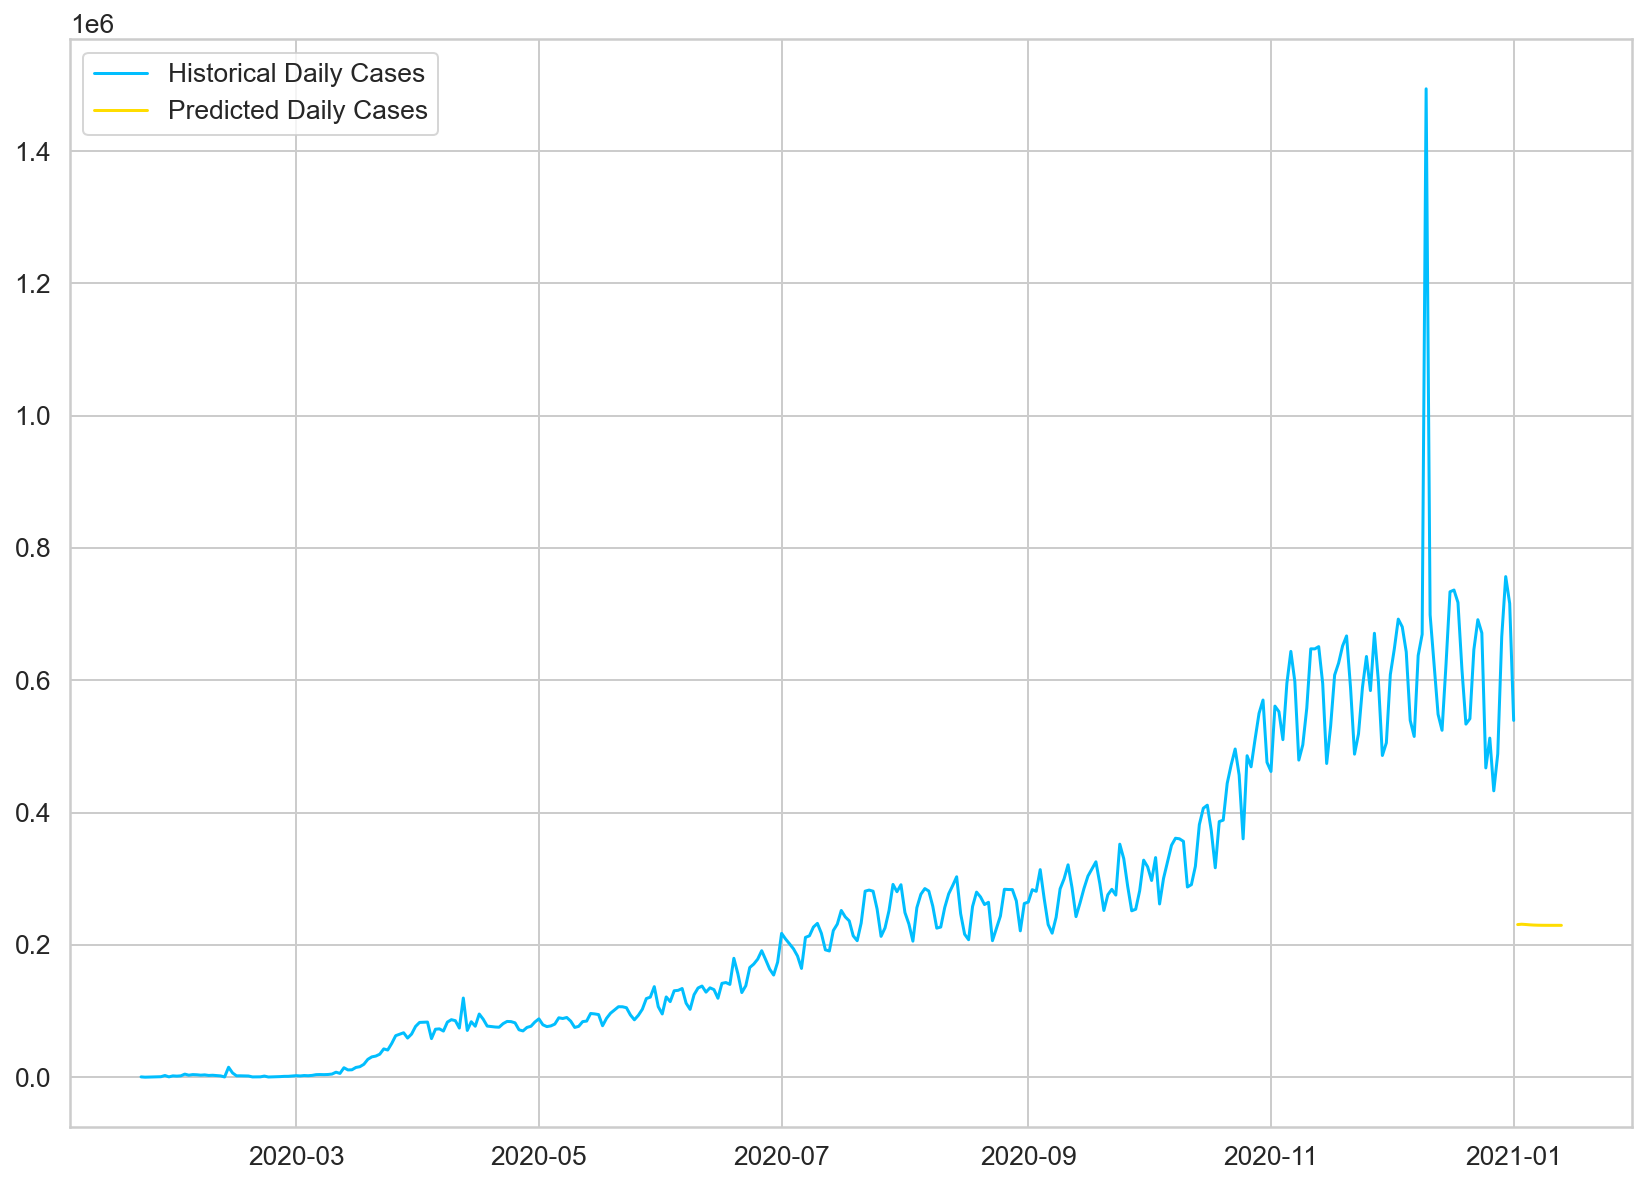

In [73]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();